In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import warnings
from tqdm import tqdm
from sklearn.manifold import trustworthiness

In [2]:
# adopted from https://github.com/jqmviegas/jqm_cvi/blob/master/jqmcvi/base.py#L72

def delta_fast(ck, cl, distances):
    values = distances[np.where(ck)][:, np.where(cl)]
    values = values[np.nonzero(values)]

    return np.min(values)
    
def big_delta_fast(ci, distances):
    values = distances[np.where(ci)][:, np.where(ci)]
    #values = values[np.nonzero(values)]
            
    return np.max(values)

def dunn_fast(points, labels):
    """ Dunn index - FAST (using sklearn pairwise euclidean_distance function)
    
    Parameters
    ----------
    points : np.array
        np.array([N, p]) of all points
    labels: np.array
        np.array([N]) labels of all points
    """
    distances = euclidean_distances(points)
    ks = np.sort(np.unique(labels))
    
    deltas = np.ones([len(ks), len(ks)])*1000000
    big_deltas = np.zeros([len(ks), 1])
    
    l_range = list(range(0, len(ks)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta_fast((labels == ks[k]), (labels == ks[l]), distances)
        
        big_deltas[k] = big_delta_fast((labels == ks[k]), distances)

    di = np.min(deltas)/np.max(big_deltas)
    return di

## For uniform centers, 10 clusters,  with normal distr, std=0.3  I go through 2, 4, 8, 16, 32, 64, 128, 256, 512 dimesnions and check how the metrics behave

For each dimension there are 10 datasets, so that we could everage the metric 

Dunn Index= $\frac{\min(\text{inter-cluster distances})}{\max(\text{intra-cluster distances})} \$

DB = $\frac{1}{n} \sum_{i=1}^{n} \max_{j\neq i}\left(\frac{\text{intra-cluster distance}(i) + \text{intra-cluster distance}(j)}{\text{inter-cluster distance}(i, j)}\right)$

CH = $\frac{\text{Between-Cluster Variance}}{\text{Within-Cluster Variance}} \times \frac{N - k}{k - 1}$
* Between-Cluster Variance is the variance between cluster means.
* Within-Cluster Variance is the variance within clusters.
* N is the total number of data points.
* k is the number of clusters.


In [3]:
std = 0.3
n_samples = 1000
n_centers = 10
n_samples_around_c = 100

datasets = {}
for i in range(1, 10):
    dim = 2 ** i
    datasets[dim] = {}
    datasets[dim]['embedings'] = []
    datasets[dim]['labels'] = []
    
    for _ in range(10):
        
        cluster_centers = np.random.uniform(0, 1,size=(n_centers, dim))
        latent_emb = []
        labels = []

        # create data
        for ci, c in enumerate(cluster_centers):
#           CAREFUL - check if you actually want to scale the variance!  
            samples = np.random.normal(c, std * np.sqrt(dim), size=(n_samples_around_c, dim))
            latent_emb.append(samples)
            labels.append(np.ones(len(samples))*ci)

        latent_emb = np.array(latent_emb).reshape(n_centers*n_samples_around_c, -1)
        labels = np.array(labels).reshape(n_centers*n_samples_around_c, -1)
        datasets[dim]['embedings'].append(latent_emb)
        datasets[dim]['labels'].append(labels)

In [4]:
clusters = list(range(2, 20)) + list(range(20, 60, 10))

In [5]:
# THIS takes like 10 mins

# Ignore all warnings
warnings.filterwarnings("ignore")

results = {}
# results['BIC'] = {} - this needs likelihood, which is not a part of k-means
# results['AIC'] = {} - this needs likelihood, which is not a part of k-means
results['dunn'] = {}
results['silhouette'] = {}
results['Davies–Bouldin'] = {}
results['Calinski-Harabasz'] = {}

for i in tqdm(range(1, 10)): 
    dim = 2 ** i
    results['dunn'][dim] = {}
    results['silhouette'][dim] = {}
    results['Davies–Bouldin'][dim] = {}
    results['Calinski-Harabasz'][dim] = {}
    for c in tqdm(clusters):
        results['dunn'][dim][c] = []
        results['silhouette'][dim][c] = []
        results['Davies–Bouldin'][dim][c] = []
        results['Calinski-Harabasz'][dim][c] = []
        
        for idx in range(10):
            loc = datasets[dim]['embedings'][idx]
            loc_lab = datasets[dim]['labels'][idx]
            
            KMean = KMeans(n_clusters=c)
            label = KMean.fit_predict(loc)
            
            results['dunn'][dim][c].append(
                dunn_fast(loc, label)
            )
            results['silhouette'][dim][c].append(
                silhouette_score(loc, label)
            )
            results['Davies–Bouldin'][dim][c].append(
                davies_bouldin_score(loc, label)
            )
            results['Calinski-Harabasz'][dim][c].append(
                calinski_harabasz_score(loc, label)
            )
           
# Reset warning filters to default behavior
warnings.filterwarnings("default")

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 15/22 [00:46<00:21,  3.14s/it]


 36%|█████████████████████████████████████████████████████████▍                                                                                                    | 8/22 [00:25<00:45,  3.26s/it]


  5%|███████▏                                                                                                                                                      | 1/22 [00:02<00:47,  2.28s/it]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 18/22 [01:04<00:16,  4.02s/it]


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 11/22 [01:03<01:20,  7.35s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [12:38<00:00, 84.25s/it]


Text(0.06, 0.5, 'metric value')

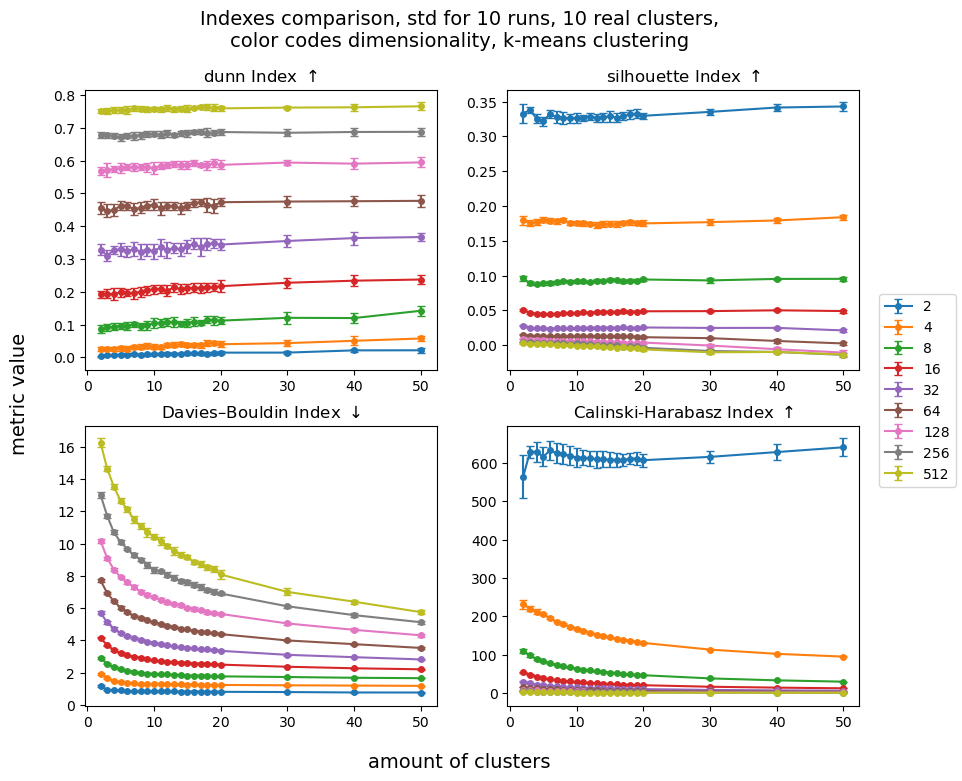

In [6]:
x = clusters
idxs = ['dunn', 'silhouette', 'Davies–Bouldin', 'Calinski-Harabasz']
idxs_label = [r'dunn Index $\uparrow$', r'silhouette Index $\uparrow$', 
              r'Davies–Bouldin Index $\downarrow$', r'Calinski-Harabasz Index $\uparrow$']
# Davies–Bouldin index (lower is better), Dunn index, silhouette score (higher is better)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for idx, ax in enumerate(axes.flatten()):
    loc_key = idxs[idx]
    for i in range(1, 10): 
        dim = 2 ** i
        y = [np.mean(results[loc_key][dim][c]) for c in clusters]
        errors = [np.sqrt(np.var(results[loc_key][dim][c])) for c in clusters]
        ax.errorbar(x, y, yerr=errors, fmt='o-', label=str(dim), markersize=4, capsize=3)
        ax.set_title(f'{idxs_label[idx]}')
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right')

# Add global title
fig.suptitle('Indexes comparison, std for 10 runs, 10 real clusters,\ncolor codes dimensionality, k-means clustering', fontsize=14)

# Add global axis label
fig.text(0.5, 0.04, 'amount of clusters', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'metric value', ha='center', va='center', rotation='vertical', fontsize=14)

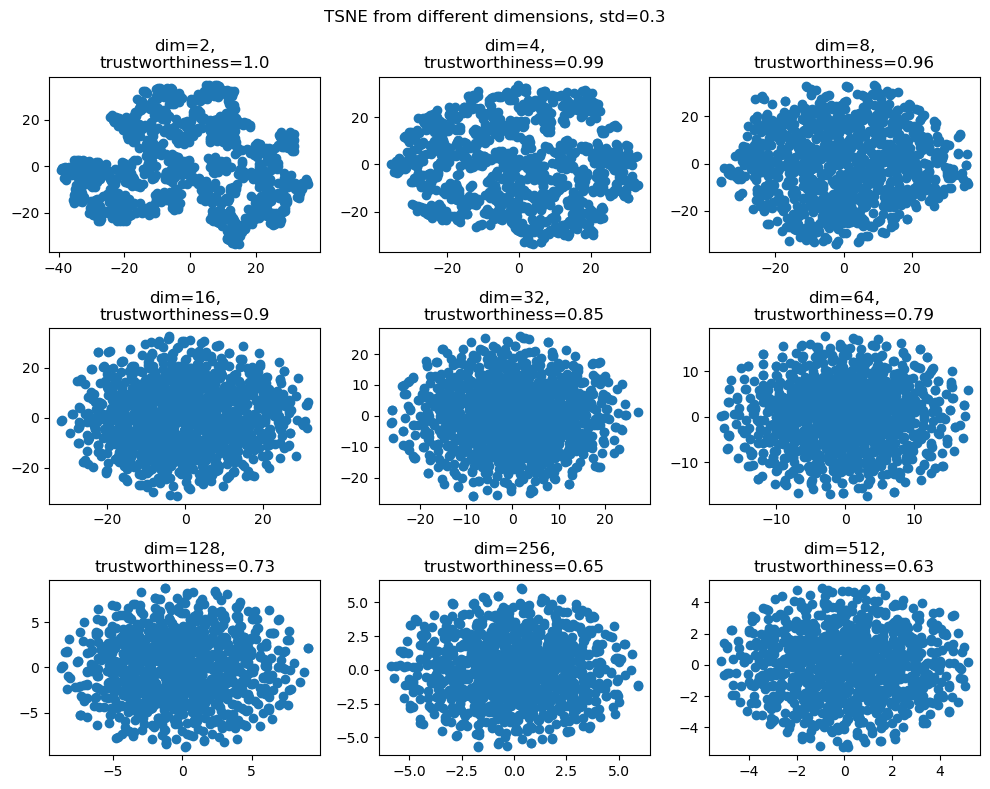

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    dim = 2 ** (i + 1)
    
    latent_emb = datasets[dim]['embedings'][0]
    tsne_emb = TSNE(n_components=2, perplexity=30).fit_transform(latent_emb)
    ax.scatter(tsne_emb[:, 0], tsne_emb[:, 1])
    trust = round(trustworthiness(latent_emb, tsne_emb), 2)
    ax.set_title(f'dim={dim},\ntrustworthiness={trust}')
 
fig.suptitle(f'TSNE from different dimensions, std={std}')
plt.tight_layout()

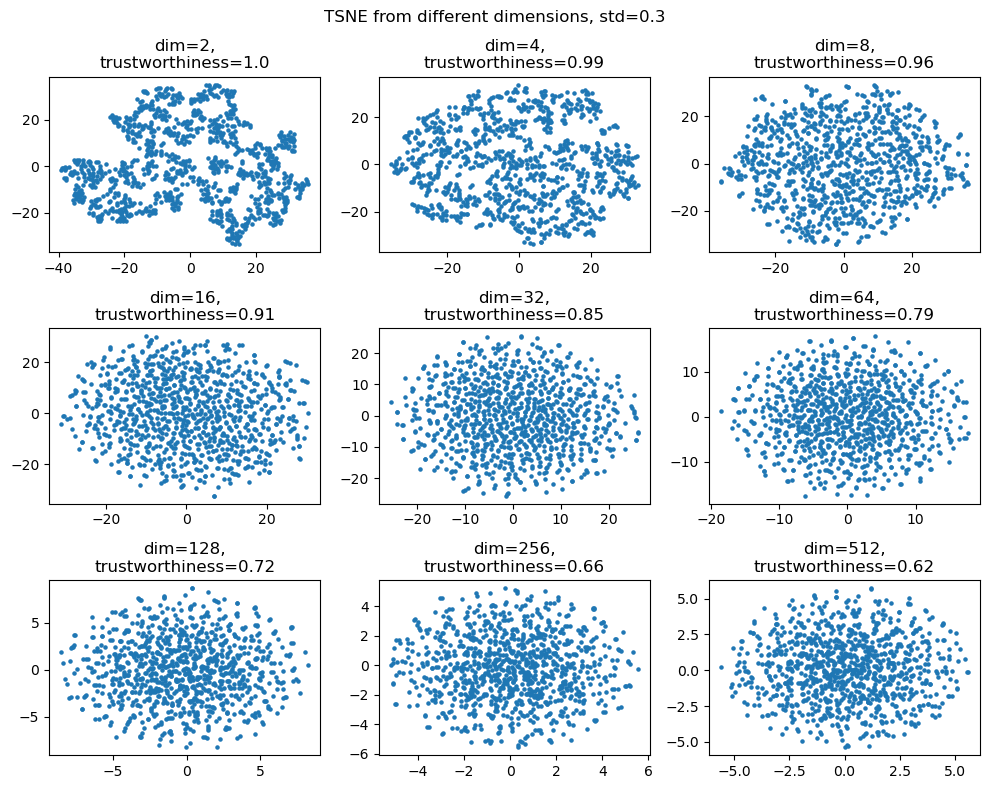

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8))
for i, ax in enumerate(axes.flatten()):
    dim = 2 ** (i + 1)
    
    latent_emb = datasets[dim]['embedings'][0]
    tsne_emb = TSNE(n_components=2, perplexity=30).fit_transform(latent_emb)
    ax.scatter(tsne_emb[:, 0], tsne_emb[:, 1], s=5)
    trust = round(trustworthiness(latent_emb, tsne_emb), 2)
    ax.set_title(f'dim={dim},\ntrustworthiness={trust}')
 
fig.suptitle(f'TSNE from different dimensions, std={std}')
plt.tight_layout()

## Scale std with sqrt(dimensions) 

https://stats.stackexchange.com/questions/129885/why-does-increasing-the-sample-size-lower-the-sampling-variance

### Seems like more then sqrt(var) noise is needed in higher dimensions  